In [87]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["ps.fonttype"] = 42

In [88]:
import wandb

api = wandb.Api()
runs = api.runs("orientino/adam-sgd-gap")

summary = []
for run in tqdm(runs):
    if run.config.get("data") not in ["c10", "c5m"]:
        continue

    entry = {}
    entry["data"] = run.config.get("data")
    entry["opt"] = run.config.get("opt")
    entry["lr"] = run.config.get("lr")
    entry["mom"] = run.config.get("mom")

    history = run.history(keys=["train/loss"], samples=20000)
    entry["tr_loss_history"] = history["train/loss"].tolist()
    entry["tr_loss"] = run.summary.get("train/loss")
    entry["vl_acc"] = run.summary.get("val/acc1")
    summary.append(entry)

len(summary)

100%|██████████| 142/142 [00:59<00:00,  2.39it/s]


128

In [89]:
len(summary[0]["tr_loss_history"])

1953

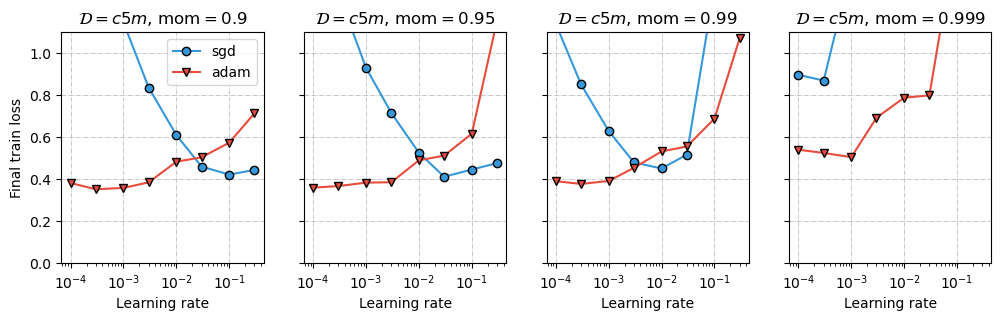

In [142]:
data = "c5m"
metric = "tr_loss"
window = 5

metric2text = {
    "tr_loss_min": "Final train loss",
    "tr_loss": "Final train loss",
    "vl_acc": "Final val acc",
}

df = pd.DataFrame(summary)
df = df[df["data"] == data]
df["tr_loss_min"] = df["tr_loss_history"].apply(lambda x: np.min(x[-window:]))
b1_unique = sorted(df["mom"].dropna().unique())

b1_n = len(b1_unique)
fig, axes = plt.subplots(1, b1_n, figsize=(3.0 * b1_n, 3.0), sharey=True)
markers = ["o", "v", "D", "X", "^", "s", "p"]
colors = {"sgd": "#3498db", "adam": "#e74c3c"}

for idx, b1_value in enumerate(b1_unique):
    subset = df[df["mom"] == b1_value]

    sgd = subset[subset["opt"] == "sgd"].sort_values("lr")
    adam = subset[subset["opt"] == "adam"].sort_values("lr")

    axes[idx].plot(
        sgd["lr"],
        sgd[metric],
        label="sgd",
        color=colors["sgd"],
        marker=markers[0],
        markeredgecolor="black",
    )
    axes[idx].plot(
        adam["lr"],
        adam[metric],
        label="adam",
        color=colors["adam"],
        marker=markers[1],
        markeredgecolor="black",
    )

    axes[idx].set_title(f"$\\mathcal{{D}}={data}$, $\\text{{mom}}={b1_value}$")
    axes[idx].set_xscale("log")
    axes[idx].set_xlabel("Learning rate")
    axes[idx].set_ylim(0.00, 1.1)
    axes[idx].grid(True, ls="-.", lw=0.5)
axes[0].set_ylabel(metric2text[metric])
axes[0].legend()

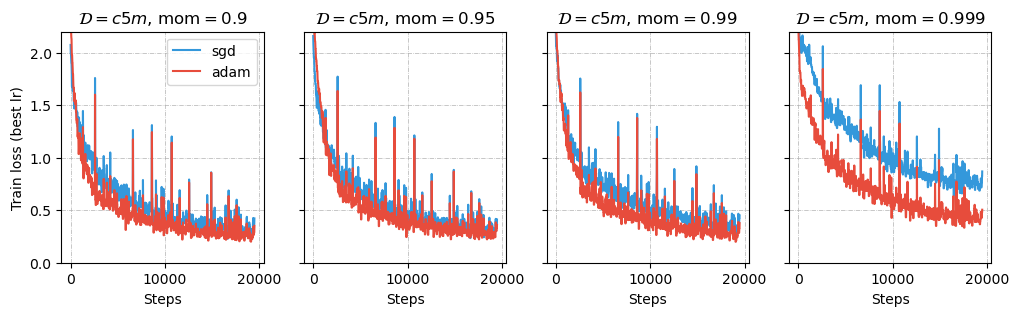

In [143]:
def smooth_min(y, window=10):
    return pd.Series(y).rolling(window).min().dropna().values


df = pd.DataFrame(summary)
df = df[df["data"] == data]
mom_unique = sorted(df["mom"].dropna().unique())

fig, axes = plt.subplots(
    1, len(mom_unique), figsize=(3.0 * len(mom_unique), 3.0), sharey=True
)
colors = {"sgd": "#3498db", "adam": "#e74c3c"}

for idx, mom in enumerate(mom_unique):
    subset = df[df["mom"] == mom]

    for opt in ["sgd", "adam"]:
        opt_subset = subset[subset["opt"] == opt].nsmallest(1, "tr_loss")
        histories = opt_subset["tr_loss_history"].tolist()
        min_len = min(len(h) for h in histories)
        histories = [h[:min_len] for h in histories]
        avg_history = smooth_min(np.mean(histories, axis=0), window)
        steps = np.arange(len(avg_history)) * 10

        axes[idx].plot(steps, avg_history, label=opt, color=colors[opt])

    axes[idx].set_title(f"$\\mathcal{{D}}={data}$, $\\text{{mom}}={mom}$")
    axes[idx].set_xlabel("Steps")
    axes[idx].grid(True, ls="-.", lw=0.5)
    axes[idx].set_ylim(0.0, 2.2)

axes[0].set_ylabel("Train loss (best lr)")
axes[0].legend()